https://jovian.ai/aakashns/06b-anime-dcgan



SyntaxError: invalid syntax (<ipython-input-4-97258b6ab3a6>, line 2)

In [8]:
!pip install opendatasets --upgrade --quiet

In [10]:
import opendatasets as od

dataset_url= "https://www.kaggle.com/datasets/kimbosoek/cosmos-images"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 

 oscargiller


Your Kaggle Key: 

 ································


  1%|          | 1.00M/104M [00:00<00:15, 6.93MB/s]

100%|██████████| 104M/104M [00:03<00:00, 29.7MB/s] 

In [11]:
import os

DATA_DIR = 'cosmos-images/data'
print(os.listdir(DATA_DIR))


['img_align_celeba']


In [13]:
print(os.listdir(DATA_DIR+'/images')[:10])

['1.jpg', '10.jpg', '1000.jpg', '10000.jpg', '10004.jpg', '10006.jpg', '10007.jpg', '10009.jpg', '10018.jpg', '1002.jpg']


In [14]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [15]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [16]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle= True, num_workers=3,pin_memory=True)

In [17]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def denorm(img_tensors):
  return img_tensors*stats[1][0] + stats[0][0]

In [19]:
def show_images(images, nmax = 64):
  fig, ax = plt.subplots(figsize =(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

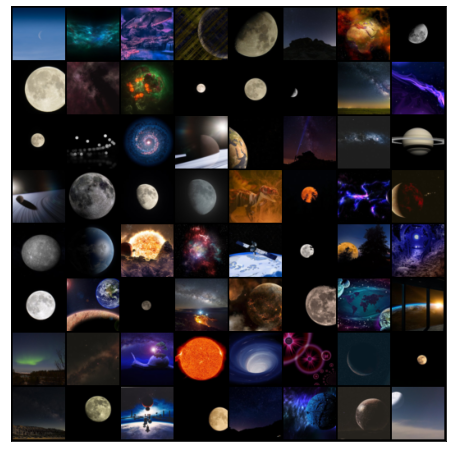

In [20]:
show_batch(train_dl)

# Using a GPU

In [21]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data,device):
  """Move tensor(s) to chosen device"""
  if isinstance(data,(list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cuda')

In [23]:
train_dl = DeviceDataLoader(train_dl,device)

In [24]:
import torch.nn as nn

In [25]:
discriminator = nn.Sequential(
    # in: 3x64x64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 64x32x32
    nn.Conv2d(64,128, kernel_size=4, stride=2, padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace = True),

    # out: 256x8x8
    nn.Conv2d(128,256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256,512, kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 512x4x4

    nn.Conv2d(512,1,kernel_size=4,stride=1, padding =0, bias = False),
    # out: 1x1x1
    nn.Flatten(),
    nn.Sigmoid()
)

In [26]:
discriminator = to_device(discriminator,device)

# Generator Network

In [27]:
latent_size = 128

In [28]:
generator = nn.Sequential(
    # in: lantent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride =1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512x4x4
    
    nn.ConvTranspose2d(512,256, kernel_size=4, stride=2, padding = 1, bias =False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256x8x8

    nn.ConvTranspose2d(256,128, kernel_size=4,stride =2,padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128x16x16

    nn.ConvTranspose2d(128,64, kernel_size=4, stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64x32x32

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
    # out: 3x64x64
)

torch.Size([128, 3, 64, 64])


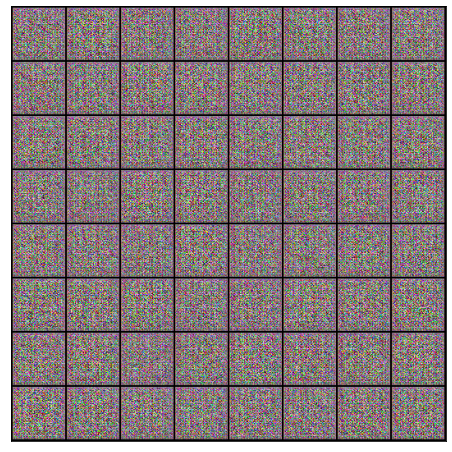

In [29]:
xb = torch.randn(batch_size, latent_size,1,1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [30]:
generator = to_device(generator,device)

#Discriminator Training

In [31]:
def train_discriminator(real_images,opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0),1, device=device)
  real_loss = F.binary_cross_entropy(real_preds,real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size,1,1,device=device)
  fake_images = generator(latent)

  # Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0),1,device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

#Generator Training

In [32]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generator fake images
  latent = torch.randn(batch_size, latent_size,1,1,device =device)
  fake_images = generator(latent)

  # Try ti fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size,1, device=device)
  loss = F.binary_cross_entropy(preds,targets)

  # Update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

In [33]:
from torchvision.utils import save_image

In [34]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

In [35]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir, fake_fname),nrow = 8)
  print('Saving', fake_fname)
  if show:
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(),nrow = 8).permute(1,2,0))

In [36]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


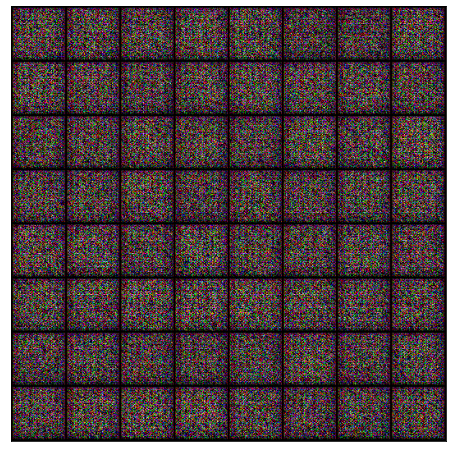

In [37]:
save_samples(0,fixed_latent)

#Full Training Loop

In [50]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [51]:
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()
  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []
  # Create optimize
  opt_d = torch.optim.Adam(discriminator.parameters(),lr = lr, betas=(0.5,0.999))
  opt_g = torch.optim.Adam(generator.parameters(),lr=lr, betas=(0.5,0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images,opt_d)
      # Train generator
      loss_g = train_generator(opt_g)

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    #Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)
  return losses_g, losses_d, real_scores, fake_scores

In [52]:
lr = 0.0002
epochs = 50

In [53]:
history = fit(epochs, lr)


Epoch [1/50], loss_g: 2.8218, loss_d: 0.5109, real_score: 0.7105, fake_score: 0.1315
Saving generated-images-0001.png



Epoch [2/50], loss_g: 3.8571, loss_d: 0.6765, real_score: 0.8810, fake_score: 0.3785
Saving generated-images-0002.png



Epoch [3/50], loss_g: 1.8874, loss_d: 0.2644, real_score: 0.8804, fake_score: 0.1047
Saving generated-images-0003.png



Epoch [4/50], loss_g: 3.5935, loss_d: 0.7486, real_score: 0.7748, fake_score: 0.3636
Saving generated-images-0004.png



Epoch [5/50], loss_g: 4.4840, loss_d: 0.4833, real_score: 0.9059, fake_score: 0.3031
Saving generated-images-0005.png



Epoch [6/50], loss_g: 0.9916, loss_d: 0.7822, real_score: 0.5466, fake_score: 0.1118
Saving generated-images-0006.png



Epoch [7/50], loss_g: 1.4616, loss_d: 0.4975, real_score: 0.7792, fake_score: 0.1980
Saving generated-images-0007.png



Epoch [8/50], loss_g: 2.1315, loss_d: 0.7046, real_score: 0.6558, fake_score: 0.1922
Saving generated-images-0008.png



Epoch [9/50], loss_g: 2.0058, loss_d: 0.5367, real_score: 0.7225, fake_score: 0.1667
Saving generated-images-0009.png



Epoch [10/50], loss_g: 1.5552, loss_d: 0.6300, real_score: 0.6250, fake_score: 0.0768
Saving generated-images-0010.png



Epoch [11/50], loss_g: 1.3927, loss_d: 0.6497, real_score: 0.6054, fake_score: 0.1006
Saving generated-images-0011.png



Epoch [12/50], loss_g: 4.0675, loss_d: 0.6822, real_score: 0.9067, fake_score: 0.4104
Saving generated-images-0012.png



Epoch [13/50], loss_g: 4.7433, loss_d: 0.6673, real_score: 0.9422, fake_score: 0.4283
Saving generated-images-0013.png



Epoch [14/50], loss_g: 5.2691, loss_d: 1.1894, real_score: 0.9433, fake_score: 0.6352
Saving generated-images-0014.png



Epoch [15/50], loss_g: 1.1225, loss_d: 0.7488, real_score: 0.5879, fake_score: 0.1671
Saving generated-images-0015.png



Epoch [16/50], loss_g: 3.3353, loss_d: 0.7038, real_score: 0.8936, fake_score: 0.4128
Saving generated-images-0016.png



Epoch [17/50], loss_g: 3.2589, loss_d: 0.6177, real_score: 0.8250, fake_score: 0.3250
Saving generated-images-0017.png



Epoch [18/50], loss_g: 5.7391, loss_d: 0.7185, real_score: 0.9655, fake_score: 0.4573
Saving generated-images-0018.png



Epoch [19/50], loss_g: 3.4867, loss_d: 0.5701, real_score: 0.8781, fake_score: 0.3279
Saving generated-images-0019.png



Epoch [20/50], loss_g: 2.4011, loss_d: 0.4427, real_score: 0.8025, fake_score: 0.1798
Saving generated-images-0020.png



Epoch [21/50], loss_g: 4.1975, loss_d: 0.6719, real_score: 0.8409, fake_score: 0.3620
Saving generated-images-0021.png



Epoch [22/50], loss_g: 2.9210, loss_d: 0.4064, real_score: 0.8547, fake_score: 0.2031
Saving generated-images-0022.png



Epoch [23/50], loss_g: 4.8445, loss_d: 0.5736, real_score: 0.9558, fake_score: 0.3840
Saving generated-images-0023.png



Epoch [24/50], loss_g: 2.2524, loss_d: 0.6466, real_score: 0.6425, fake_score: 0.1584
Saving generated-images-0024.png



Epoch [25/50], loss_g: 2.7088, loss_d: 0.2672, real_score: 0.8490, fake_score: 0.0875
Saving generated-images-0025.png



Epoch [26/50], loss_g: 3.4355, loss_d: 0.4157, real_score: 0.8613, fake_score: 0.2126
Saving generated-images-0026.png



Epoch [27/50], loss_g: 2.9081, loss_d: 0.5539, real_score: 0.8162, fake_score: 0.2682
Saving generated-images-0027.png



Epoch [28/50], loss_g: 1.5145, loss_d: 0.5898, real_score: 0.6818, fake_score: 0.1473
Saving generated-images-0028.png



Epoch [29/50], loss_g: 2.4280, loss_d: 0.4612, real_score: 0.7094, fake_score: 0.0775
Saving generated-images-0029.png



Epoch [30/50], loss_g: 3.2433, loss_d: 0.5199, real_score: 0.8578, fake_score: 0.2719
Saving generated-images-0030.png



Epoch [31/50], loss_g: 3.5847, loss_d: 0.3341, real_score: 0.9154, fake_score: 0.2064
Saving generated-images-0031.png



Epoch [32/50], loss_g: 2.3212, loss_d: 0.5092, real_score: 0.7694, fake_score: 0.1966
Saving generated-images-0032.png



Epoch [33/50], loss_g: 2.6651, loss_d: 0.2405, real_score: 0.8930, fake_score: 0.1103
Saving generated-images-0033.png



Epoch [34/50], loss_g: 0.4159, loss_d: 1.3457, real_score: 0.3154, fake_score: 0.0369
Saving generated-images-0034.png



Epoch [35/50], loss_g: 1.6249, loss_d: 0.7990, real_score: 0.5592, fake_score: 0.1055
Saving generated-images-0035.png



Epoch [36/50], loss_g: 4.1865, loss_d: 0.3840, real_score: 0.9418, fake_score: 0.2648
Saving generated-images-0036.png



Epoch [37/50], loss_g: 2.1748, loss_d: 0.4121, real_score: 0.7857, fake_score: 0.1404
Saving generated-images-0037.png



Epoch [38/50], loss_g: 2.4492, loss_d: 0.6442, real_score: 0.6654, fake_score: 0.1382
Saving generated-images-0038.png



Epoch [39/50], loss_g: 2.5274, loss_d: 0.4100, real_score: 0.7265, fake_score: 0.0592
Saving generated-images-0039.png



Epoch [40/50], loss_g: 5.3077, loss_d: 1.1326, real_score: 0.9736, fake_score: 0.6129
Saving generated-images-0040.png



Epoch [41/50], loss_g: 4.7752, loss_d: 0.7727, real_score: 0.9530, fake_score: 0.4577
Saving generated-images-0041.png



Epoch [42/50], loss_g: 2.3424, loss_d: 0.5010, real_score: 0.8634, fake_score: 0.2657
Saving generated-images-0042.png



Epoch [43/50], loss_g: 3.3989, loss_d: 0.7039, real_score: 0.7720, fake_score: 0.3215
Saving generated-images-0043.png



Epoch [44/50], loss_g: 2.5702, loss_d: 0.3203, real_score: 0.8274, fake_score: 0.1032
Saving generated-images-0044.png



Epoch [45/50], loss_g: 2.6511, loss_d: 0.5589, real_score: 0.8333, fake_score: 0.2681
Saving generated-images-0045.png



Epoch [46/50], loss_g: 1.7420, loss_d: 0.5809, real_score: 0.6483, fake_score: 0.0849
Saving generated-images-0046.png



Epoch [47/50], loss_g: 3.0421, loss_d: 0.3144, real_score: 0.9017, fake_score: 0.1763
Saving generated-images-0047.png



Epoch [48/50], loss_g: 4.0419, loss_d: 0.3297, real_score: 0.9387, fake_score: 0.2200
Saving generated-images-0048.png



Epoch [49/50], loss_g: 3.1688, loss_d: 0.5804, real_score: 0.9206, fake_score: 0.3530
Saving generated-images-0049.png



Epoch [50/50], loss_g: 2.5036, loss_d: 0.4924, real_score: 0.7050, fake_score: 0.1070
Saving generated-images-0050.png


In [54]:
losses_g, losses_d, real_scores, fake_scores = history

In [55]:
# Save the model checkpoint
torch.save(generator.state_dict(),'G.pth')
torch.save(discriminator.state_dict(),'D.pth')

In [56]:
from IPython.display import Image

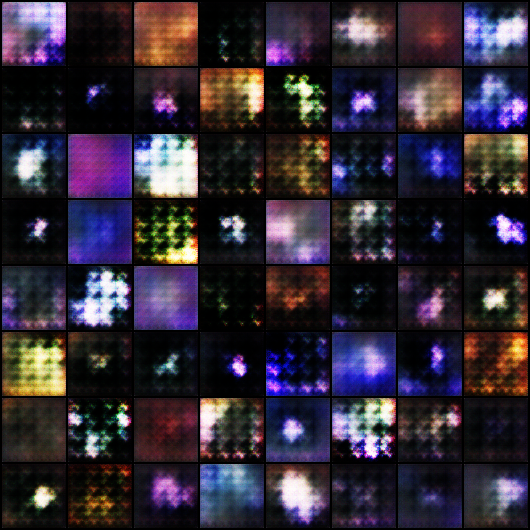

In [57]:
Image('./generated/generated-images-0001.png')

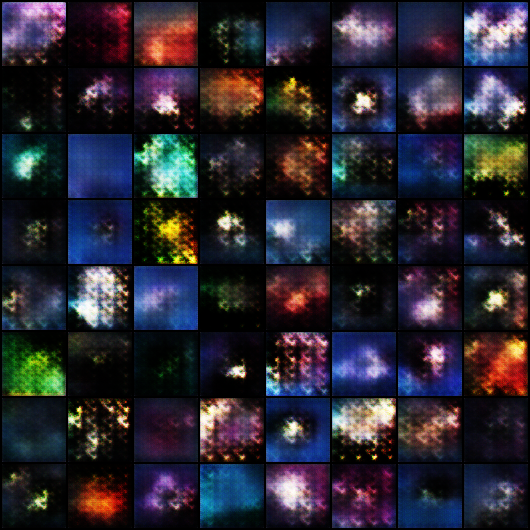

In [58]:
Image('./generated/generated-images-0005.png')

In [59]:
import cv2
import os

vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'),1,(530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Text(0.5, 1.0, 'Losses')

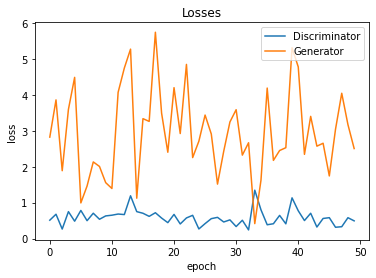

In [60]:
plt.plot(losses_d,'-')
plt.plot(losses_g,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

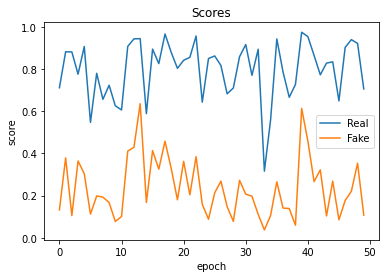

In [61]:
plt.plot(real_scores,'-')
plt.plot(fake_scores,'-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real','Fake'])
plt.title('Scores')

In [62]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import skimage.color as color
from ipywidgets import VBox, HBox, FloatSlider

# For importing from alternative directory sources
import sys  
sys.path.insert(0, '../dip_utils')

#import matrix_utils
from vis_utils import (vis_rgb_cube,
                       vis_hsv_cube,
                       vis_hists,
                       lab_uniform)

ModuleNotFoundError: No module named 'matrix_utils'

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

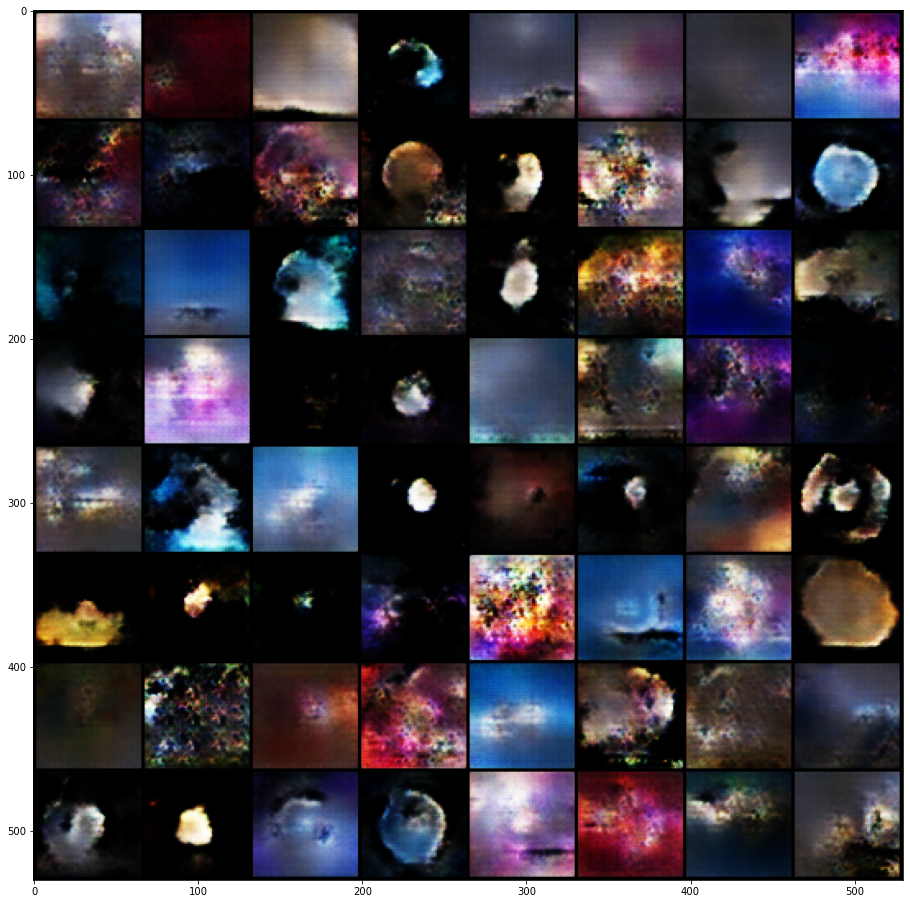

In [67]:
I = plt.imread("./generated/generated-images-0040.png")
plt.figure(figsize=(16,16))
plt.imshow(I)